# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, H. Janati, M. Massias

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 22nd of november at noon**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [32]:
# Change here using YOUR first and last names
fn1 = "bryan"
ln1 = "chen"
fn2 = "alice"
ln2 = "devilder"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_chen_bryan_and_devilder_alice.ipynb


In [33]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

import time

In [34]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

C:\Users\Bradf\AppData\Local\Temp\ipykernel_14228\428856815.py:4: DeprecationWarning: Please import `toeplitz` from the `scipy.linalg` namespace; the `scipy.linalg.special_matrices` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.linalg.special_matrices import toeplitz


## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$


<div class="alert alert-success">
    <b>QUESTION 1:</b> We ask you to code
     <ul>
         <li>cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$</li>
         <li>greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.
</li>
    </ul>
</div>

**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [35]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [36]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]
        w[j] += A[:, j].dot(residuals) / lips_const[j]
        # update residuals:
        residuals += A[:, j] * (old_w_j - w[j])
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(np.abs(gradient))
        old_w_j = w[j]
        w[j] -= gradient[j] / lips_const[j]
        # update gradient:
        gradient += gram[:, j] * (w[j] - old_w_j)
        # END TODO
        
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Compute a precise minimum with your favorite solver</li>
         <li>Compare the performance of cyclic and greedy CD as function of iterations.</li>
         <li>From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.</li>
    </ul>
</div>

**Remark:** You will do the plots using the number of iterations on the x-axis and not time as your code is likely to be slow unless you use [numba](https://numba.pydata.org/).

In [37]:
def loss_linreg(A, b, w):
    """Least-squares loss"""
    return np.linalg.norm(b - A @ w, ord=2)**2/2

def grad_linreg(A, b, w):
    """Leas-squares gradient"""
    return - A.T @ (b - A @ w)

### 1. Compute a precise minimum with your favorite solver

In [38]:
from numpy.linalg import lstsq

w_min, _, _, _ = lstsq(A, b, rcond=None)
min_lstsq = loss_linreg(A, b, w_min)

# print(w_min)
print(f"Precise minimum with favorite solver (lstsq) = {min_lstsq} \n")
print(f"Gradient norm at w_min = {norm(grad_linreg(A, b, w_min))}")

Precise minimum with favorite solver (lstsq) = 466.38497653376555 

Gradient norm at w_min = 2.7933856288757404e-11


### 2. Compare the performance of cyclic and greedy CD as function of iterations

In [39]:
n_iter = 3000

start_time = time.time()
w_cyclic, all_objs_cyclic = cyclic_cd(A, b, n_iter)
print(f"Duration of cyclic coordinate descent = {time.time() - start_time:.3f} seconds \n")
start_time = time.time()
w_greedy, all_objs_greedy = greedy_cd(A, b, n_iter)
print(f"Duration of greedy coordinate descent = {time.time() - start_time:.3f} seconds \n")

print(f"Precise minimum with cyclic coordinate descent = {loss_linreg(A, b, w_cyclic)} ")
print(f"Gradient norm at w_cyclic = {norm(grad_linreg(A, b, w_cyclic))} \n")
print(f"Precise minimum with greedy coordinate descent = {loss_linreg(A, b, w_greedy)}")
print(f"Gradient norm at w_greedy = {norm(grad_linreg(A, b, w_greedy))}")

Duration of cyclic coordinate descent = 0.011 seconds 

Duration of greedy coordinate descent = 0.018 seconds 

Precise minimum with cyclic coordinate descent = 466.3849765339347 
Gradient norm at w_cyclic = 0.00030884372312971463 

Precise minimum with greedy coordinate descent = 466.3849765337659
Gradient norm at w_greedy = 1.0335129758710965e-05


Remark: We notice that the greedy coordinate descent gives a slightly better solution than the cyclic one because the gradient norm is smaller.

In [40]:
print(min_lstsq)

466.38497653376555


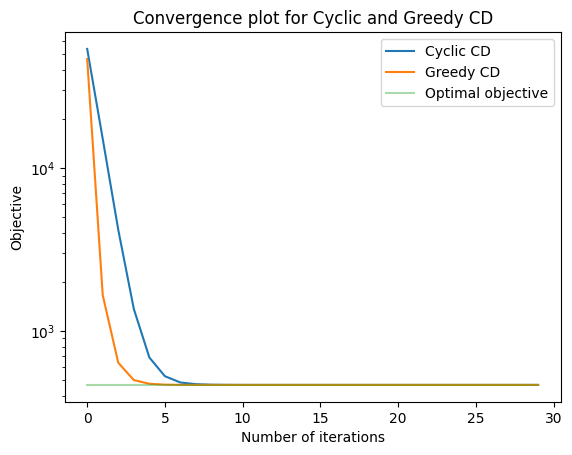

In [41]:
list_opt_min = [min_lstsq for i in range(min(len(all_objs_greedy), 100))]

plt.plot(all_objs_cyclic, label='Cyclic CD')
plt.plot(all_objs_greedy, label='Greedy CD')
plt.plot(list_opt_min, label='Optimal objective', alpha=0.4)
plt.xlabel('Number of iterations')
plt.ylabel('Objective')
plt.title('Convergence plot for Cyclic and Greedy CD')
plt.yscale('log')
plt.legend()
plt.show()

**Comments:**

We can observe that the Greedy Coordinate Descent converges faster than the Cyclic Coordinate Descent. This is due to the fact that the Greedy CD selects the coordinate that has the largest gradient in magnitude, which allows it to converge faster. The Greedy CD reaches the minimum in 5 iterations, while the Cyclic CD reaches it in 7 iterations.

### 3. From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers

* **Greedy CD for L2-regularized logistic regression:**

Greedy CD can be used because the logistic loss is convex, and the L2 regularization term is also convex. Calculating all partial gradients at each iteration is computationally intensive for large datasets. However, for problems with a moderate number of features, it can be practical.

* **Greedy CD for OLS with 100,000 features:**

Using CD for OLS with 100,000 features is not efficient and computing all partial gradients at each iteration is impractical due to computational and memory constraints. OLS has a quadratic loss function, and while coordinate descent can be applied, each coordinate update involves computing the residuals and updating them, which can be costly when the number of features is large. The benefit of CD diminishes in high-dimensional settings because the per-iteration cost and the total number of iterations (in terms of computational time) increase.

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$

<div class="alert alert-success">
    <b>QUESTION 3:</b><br/>
    Assuming uniqueness of the solution, show that: 
</div>

$$
\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0
, \text{where }\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}
$$

**HINT:** You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$
\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) 
$$

where $\times$ is the Cartesian product between sets,
and 
$$ 
\partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

**Comments:**

To show that $\hat{w} = 0_p$ is the unique minimizer if and only if $\lambda \geq \lambda_{\max} := \frac{1}{2}\|X^\top y\|_\infty$, we use subgradient optimality conditions for convex functions.

Consider the optimization problem:

$$
\hat{w} \in \operatorname*{arg\,min}_{w \in \mathbb{R}^p} \left[ f(w) + \lambda \|w\|_1 \right],
$$

where

$$
f(w) = \sum_{i=1}^{n} \log\left(1 + e^{-y_i w^\top x_i}\right).
$$

The gradient of $f(w)$ with respect to $w$ is:

$$
\nabla f(w) = -\sum_{i=1}^{n} y_i x_i \frac{e^{-y_i w^\top x_i}}{1 + e^{-y_i w^\top x_i}} = -\sum_{i=1}^{n} y_i x_i \sigma(-y_i w^\top x_i),
$$

where $\sigma(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid function.

At $w = 0_p$, since $\sigma(0) = \frac{1}{2}$, we have:

$$
\begin{align*}
\nabla f(0_p) &= -\sum_{i=1}^{n} y_i x_i \left( \frac{1}{2} \right) \\
&= -\frac{1}{2} X^\top y.
\end{align*}
$$

The subdifferential of the $L_1$-norm at $w = 0_p$ is:

$$
\partial \|w\|_1 \big|_{w=0_p} = [-1, 1]^p.
$$

The necessary and sufficient condition for $w = 0_p$ to be a minimizer is:

$$
0 \in \nabla f(0_p) + \lambda \, \partial \|w\|_1 \big|_{w=0_p}.
$$

Substituting the computed gradient and subdifferential, we get:

$$
0 \in -\frac{1}{2} X^\top y + \lambda s, \quad \text{where } s \in [-1, 1]^p.
$$

This implies:

$$
\frac{1}{2} X^\top y \in \lambda s, \quad s \in [-1, 1]^p.
$$

Therefore, for each component $j$:

$$
\left| \frac{1}{2} (X^\top y)_j \right| \leq \lambda.
$$

This leads to the condition:

$$
\lambda \geq \frac{1}{2} \| X^\top y \|_\infty = \lambda_{\max}.
$$

Hence, if $\lambda \geq \lambda_{\max}$, then $w = 0_p$ satisfies the optimality condition and is the unique minimizer. Conversely, if $\hat{w} = 0_p$ is the unique minimizer, the optimality condition must hold, implying $\lambda \geq \lambda_{\max}$.

Therefore, we conclude that:

$$
\lambda \geq \lambda_{\max} \quad \Leftrightarrow \quad \hat{w} = 0_p.
$$

<div class="alert alert-success">
    <b>QUESTION 4:</b><br/>
    Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.
</div>

**Comments:**

To show that for sparse logistic regression, the coordinate-wise Lipschitz constant of the smooth term $\gamma_j$ can be taken equal to $\| X_j \|^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.

Indeed, we have the smooth part of the logistic regression objective function such that:

$$
f(w) = \sum_{i=1}^{n} \log\left(1 + e^{- y_i w^\top x_i}\right).
$$

We are interested in finding the Lipschitz constant $\gamma_j$ for the gradient component $\frac{\partial f}{\partial w_j}(w)$ with respect to $w_j$. Specifically, we need to find $\gamma_j$ such that for all $w, w'$:

$$
\left| \frac{\partial f}{\partial w_j}(w) - \frac{\partial f}{\partial w_j}(w') \right| \leq \gamma_j \left| w_j - w_j' \right|.
$$

We also have that the partial derivative of $f(w)$ with respect to $w_j$:

$$
\frac{\partial f}{\partial w_j}(w) = \sum_{i=1}^{n} -y_i x_{ij} \sigma(- y_i w^\top x_i),
$$

where $\sigma(t) = \frac{1}{1 + e^{-t}}$ is the sigmoid function.

Then, the second derivative with respect to $w_j$ is:

$$
\frac{\partial^2 f}{\partial w_j^2}(w) = \sum_{i=1}^{n} x_{ij}^2 \sigma(- y_i w^\top x_i) \left(1 - \sigma(- y_i w^\top x_i)\right).
$$

Note that for any real number $t$, the product $\sigma(t)(1 - \sigma(t))$ attains its maximum value of $\frac{1}{4}$ when $t = 0$, and is always non-negative and less than or equal to $\frac{1}{4}$. Therefore, we have for $\| X_j \|^2 = \sum_{i=1}^{n} x_{ij}^2$:

$$
\frac{\partial^2 f}{\partial w_j^2}(w) \leq \frac{1}{4} \sum_{i=1}^{n} x_{ij}^2 = \frac{1}{4} \| X_j \|^2,
$$

Since the second derivative provides an upper bound on the rate of change of the gradient, the Lipschitz constant $\gamma_j$ for the gradient component $\frac{\partial f}{\partial w_j}(w)$ can be taken as $\gamma_j = \frac{1}{4} \| X_j \|^2$.

Therefore, for sparse logistic regression, the coordinate-wise Lipschitz constant of the smooth term $\gamma_j$ can be taken equal to $\| X_j \|^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.

<div class="alert alert-success">
    <b>QUESTION 5:</b><br/>
    Code cyclic proximal coordinate descent for sparse Logistic regression:
</div>

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [42]:
def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)

In [43]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(X, ord=2, axis=0) ** 2 / 4
    # END TODO

    all_objs = np.zeros(n_iter)

    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j = -sum(y * X[:, j] * sigmoid(-y * Xw))
            w[j] = soft_thresh(w[j] - grad_j / lips_const[j], lamb / lips_const[j])
            
            if old_w_j != w[j]:
                Xw += (w[j] - old_w_j) * X[:, j]
            #END TODO
            
        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs

In [44]:
w , all_objs_lcsp = cd_logreg(X,y,lamb,n_iter=50)

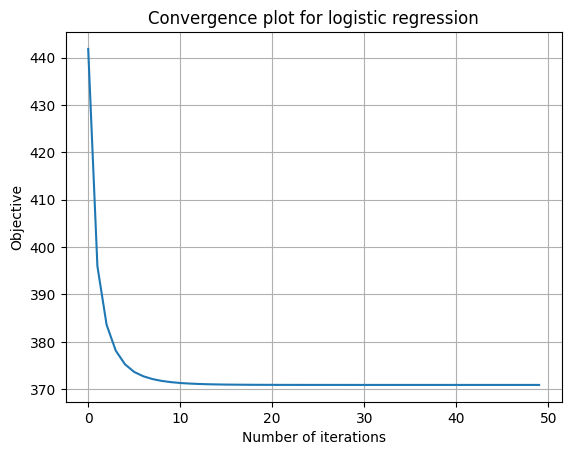

In [45]:
plt.plot(all_objs_lcsp)
plt.xlabel('Number of iterations')
plt.ylabel('Objective')
plt.title('Convergence plot for logistic regression')
plt.grid()
plt.show()

**Comments:**

We observe that the cyclic proximal coordinate descent converges in 15 iterations. The Lipschitz constant for each coordinate is computed as $\gamma_j = \| X_j \|^2 / 4$. We used the proximal operator of the L1 norm, which is the soft-thresholding operator. The soft-thresholding operator is applied to each coordinate of the gradient of the smooth term of the objective function.

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [46]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

c:\Users\Bradf\anaconda3\envs\hiparis\lib\site-packages\sklearn\datasets\_openml.py:320: UserWarning: Multiple active versions of the dataset matching the name leukemia exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=1104
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=45090

  warn(warning_msg)


Check the sparsity of the dataset 

In [47]:
total_entries = X.shape[0] * X.shape[1]

num_zeros = np.sum(X == 0)

sparsity = num_zeros / total_entries
print(f"Sparsity: {sparsity * 100:.2f}%")

Sparsity: 0.31%


Therefore, the dataset is not considered sparse, but dense. 

In [48]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

(72, 7129)


In [49]:
n_features = X.shape[1]

In [50]:
w_true = np.linalg.lstsq(X, y, rcond=None)[0]

<div class="alert alert-success">
    <b>QUESTION 6:</b> Code
    <ul>
        <li>a simple proximal gradient solver for the Lasso</li>
        <li>a prox CD solver for the Lasso and compare them on this dataset.</li>
    </ul>
</div>

**Remark:** Do the plots in terms of epochs, not updates (to be fair to CD).

In [51]:
def l1_norm(w, lmbd):
    return lmbd * np.linalg.norm(w, ord=1)

In [52]:
def PGD_lasso(w0, lmbd=0., n_iter=50,
         w_true=w_true, verbose=True):
    """Proximal gradient descent algorithm
    """
    w = w0.copy()
    w_new = w0.copy()
    # n_samples and n_features are not used (they could be parameters for the grad_f function) in the function because they are global variables
    n_samples, n_features = X.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(w - w_true) / norm(w_true)
    errors.append(err)
    # Current objective
    obj = loss_linreg(X,y,w) + l1_norm(w, lmbd)
    objectives.append(obj)
    # Lipschitz constant of the gradient of f
    lips_const = np.linalg.norm(X, ord=2) ** 2

    if verbose:
        print("Lauching PGDsolver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        
        w_new = w - grad_linreg(X, y, w)/lips_const
        w = soft_thresh(w_new, lmbd/lips_const)

        obj = loss_linreg(X,y,w) + l1_norm(w, lmbd)
        err = norm(w - w_true) / norm(w_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return w, objectives, errors


In [53]:
def cd_linreg(X, y, lamb, n_iter):
    """Proximal CD for Lasso (linear regression with L1 penalization)"""
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(X, ord=2, axis=0) ** 2
    # END TODO
    
    all_objs = np.zeros(n_iter)

    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j = X[:, j].dot(Xw - y) 
            w[j] = soft_thresh(w[j] - grad_j / lips_const[j], lamb / lips_const[j])
            
            if old_w_j != w[j]:
                Xw += (w[j] - old_w_j) * X[:, j]
            # END TODO
            
        all_objs[t] = 0.5 * np.linalg.norm(y - Xw) ** 2 + lamb * norm(w, ord=1)
    
    return w, all_objs

In [54]:
n_epochs = 10

w_pgd, obj_pgd, err_pgd = PGD_lasso(np.zeros(n_features), lmbd=lambd, n_iter=n_epochs*n_features, verbose=True)

w_cd, all_objs_cd = cd_linreg(X, y, lambd, n_iter=n_epochs)

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 3.44e+01 | 9.98e-01
      10 | 3.36e+01 | 9.92e-01
      20 | 3.31e+01 | 9.87e-01
      30 | 3.28e+01 | 9.83e-01
      40 | 3.24e+01 | 9.79e-01
      50 | 3.21e+01 | 9.76e-01
      60 | 3.19e+01 | 9.73e-01
      70 | 3.17e+01 | 9.70e-01
      80 | 3.14e+01 | 9.67e-01
      90 | 3.12e+01 | 9.65e-01
     100 | 3.10e+01 | 9.62e-01
     110 | 3.09e+01 | 9.60e-01
     120 | 3.07e+01 | 9.59e-01
     130 | 3.05e+01 | 9.57e-01
     140 | 3.04e+01 | 9.55e-01
     150 | 3.03e+01 | 9.54e-01
     160 | 3.01e+01 | 9.53e-01
     170 | 3.00e+01 | 9.51e-01
     180 | 2.99e+01 | 9.50e-01
     190 | 2.98e+01 | 9.49e-01
     200 | 2.97e+01 | 9.49e-01
     210 | 2.95e+01 | 9.48e-01
     220 | 2.94e+01 | 9.47e-01
     230 | 2.94e+01 | 9.46e-01
     240 | 2.93e+01 | 9.46e-01
     250 | 2.92e+01 | 9.45e-01
     260 | 2.91e+01 | 9.45e-01
     270 | 2.90e+01 | 9.44e-01
     280 | 2.89e+01 | 9.44e-01
     290 | 2.89e+01 | 9.43e-01
     300 | 2.88e+

In [55]:
dist_min_cd = [norm(ob - obj_pgd[-1]) for ob in all_objs_cd]
dist_min_pgd = [norm(ob - obj_pgd[-1]) for ob in obj_pgd[: :n_features]]

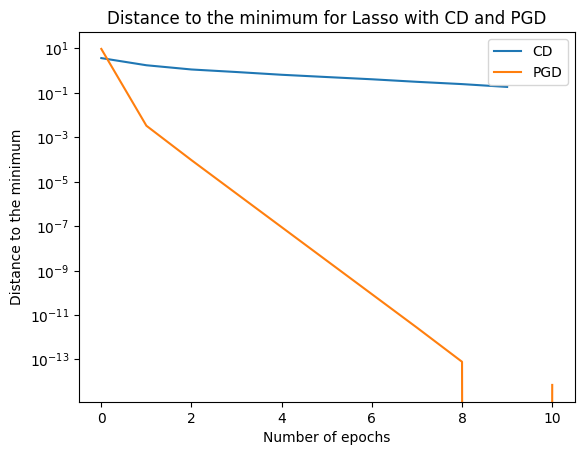

In [56]:
plt.semilogy(dist_min_cd, label='CD')
plt.semilogy(dist_min_pgd, label='PGD')
plt.xlabel('Number of epochs')
plt.ylabel('Distance to the minimum')
plt.title('Distance to the minimum for Lasso with CD and PGD')
plt.legend()
plt.show()

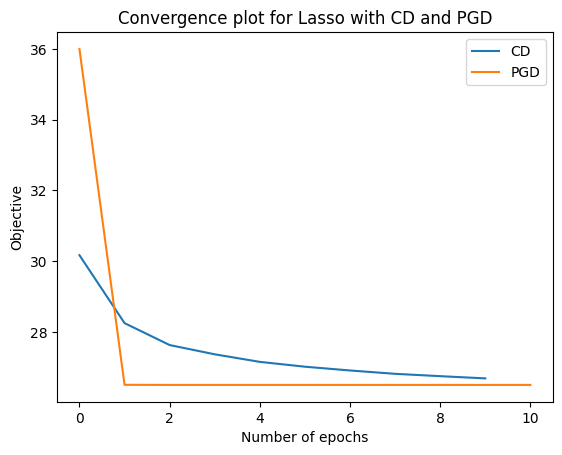

In [57]:
plt.plot(all_objs_cd, label='CD')
plt.plot(obj_pgd[: :n_features], label='PGD')
plt.xlabel('Number of epochs')
plt.ylabel('Objective')
plt.title('Convergence plot for Lasso with CD and PGD')
plt.legend()
plt.show()

**Comments:**

We plot the objectives of the proximal gradient and proximal CD solvers as a function of the number of epochs in order to be fair to CD. We observe that the proximal gradient solver converges faster than the proximal CD solver (due to the fact that the data is not sparse). The proximal CD solver requires more epochs to converge because it updates only one coordinate at a time, while the proximal gradient solver updates all coordinates simultaneously and the feature size is quite important. Moreover, both algorithms reach the same minimum value of the objective function.

### Sparse Logistic Regression on the Leukemia Dataset (classification)

In [58]:
def loss_logreg(X, y, w):
    """Logistic loss"""
    return np.log(1. + np.exp(-y * X.dot(w))).sum()

def grad_logreg(X, y, w):
    """Logistic gradient"""
    return -(y * X.T * sigmoid(-y * X.dot(w))).sum(axis=1)

In [59]:
def PGD_lasso_logreg(w0, lmbd=0., n_iter=50,
         w_true=w_true, verbose=True):
    """Proximal gradient descent algorithm
    """
    w = w0.copy()
    w_new = w0.copy()
    # n_samples and n_features are not used (they could be parameters for the grad_f function) in the function because they are global variables
    n_samples, n_features = X.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(w - w_true) / norm(w_true)
    errors.append(err)
    # Current objective
    obj = loss_logreg(X,y,w) + l1_norm(w, lmbd)
    objectives.append(obj)
    # Lipschitz constant of the gradient of f
    lips_const = np.linalg.norm(X, ord=2) ** 2 / 4
    
    if verbose:
        print("Lauching PGDsolver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        
        w_new = w - grad_logreg(X, y, w)/lips_const
        w = soft_thresh(w_new, lmbd/lips_const)

        obj = loss_logreg(X,y,w) + l1_norm(w, lmbd)
        err = norm(w - w_true) / norm(w_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return w, objectives, errors

In [60]:
n_epochs = 10

w_pgd_logreg, obj_pgd_logreg, err_pgd_logreg = PGD_lasso_logreg(np.zeros(n_features), lmbd=lambd, n_iter=n_epochs*n_features, verbose=True)

w_cd_logreg, all_objs_cd_logreg = cd_logreg(X, y, lambd, n_iter=n_epochs)

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 4.93e+01 | 9.99e-01
      10 | 4.89e+01 | 9.95e-01
      20 | 4.88e+01 | 9.94e-01
      30 | 4.87e+01 | 9.93e-01
      40 | 4.87e+01 | 9.92e-01
      50 | 4.87e+01 | 9.91e-01
      60 | 4.86e+01 | 9.91e-01
      70 | 4.86e+01 | 9.91e-01
      80 | 4.86e+01 | 9.91e-01
      90 | 4.86e+01 | 9.91e-01
     100 | 4.86e+01 | 9.91e-01
     110 | 4.86e+01 | 9.90e-01
     120 | 4.85e+01 | 9.90e-01
     130 | 4.85e+01 | 9.90e-01
     140 | 4.85e+01 | 9.90e-01
     150 | 4.85e+01 | 9.90e-01
     160 | 4.85e+01 | 9.90e-01
     170 | 4.85e+01 | 9.90e-01
     180 | 4.85e+01 | 9.90e-01
     190 | 4.85e+01 | 9.90e-01
     200 | 4.85e+01 | 9.90e-01
     210 | 4.85e+01 | 9.90e-01
     220 | 4.85e+01 | 9.90e-01
     230 | 4.85e+01 | 9.90e-01
     240 | 4.84e+01 | 9.90e-01
     250 | 4.84e+01 | 9.90e-01
     260 | 4.84e+01 | 9.90e-01
     270 | 4.84e+01 | 9.90e-01
     280 | 4.84e+01 | 9.90e-01
     290 | 4.84e+01 | 9.90e-01
     300 | 4.84e+

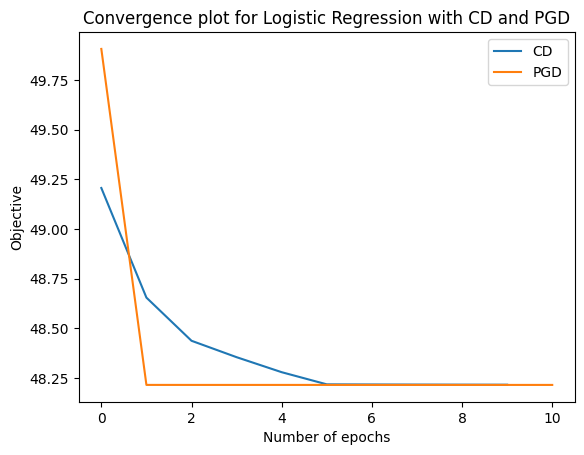

In [61]:
plt.plot(all_objs_cd_logreg, label='CD')
plt.plot(obj_pgd_logreg[: :n_features], label='PGD')
plt.xlabel('Number of epochs')
plt.ylabel('Objective')
plt.title('Convergence plot for Logistic Regression with CD and PGD')
plt.legend()
plt.show()

**Comments:** 

For logistic regression, we observe that the proximal gradient solver converges faster than the proximal CD solver (due to the fact that the data is not sparse). The proximal CD solver requires more epochs to converge because it updates only one coordinate at a time, while the proximal gradient solver updates all coordinates simultaneously and the feature size is quite important. We also observe that both algorithms reach the same minimum value of the objective function.